In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as utils

import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!git clone https://github.com/Sitnich/ssyp-2022-materials

Cloning into 'ssyp-2022-materials'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 29 (delta 2), reused 2 (delta 0), pack-reused 21
Unpacking objects: 100% (29/29), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/ssyp-2022-materials/data/pokemon.zip -d /content/drive/MyDrive/pokemon

Mounted at /content/drive
Archive:  /content/ssyp-2022-materials/data/pokemon.zip
replace /content/drive/MyDrive/pokemon/official-jpg-named/abomasnow.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
dataset = datasets.ImageFolder(root='/content/drive/MyDrive/pokemon',
       transform=transforms.Compose([
       transforms.Resize(size=[64,64]),
       transforms.RandomHorizontalFlip(),
       transforms.RandomRotation(degrees=[0.2, 0.8]),
       transforms.ToTensor(),
       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))

trainloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
def plot_images(images, ncol=12, figsize=(8,8)):
    def imshow(img, figsize_inner):
      img = img / 2 + 0.5 # нормализация: [-1,1] --> [0,1]
      npimg = img.numpy()
      plt.figure(figsize = figsize_inner)
      plt.imshow(np.transpose(npimg, (1, 2, 0)))
    imshow(utils.make_grid(images, nrow=ncol), figsize_inner=figsize)

tensor(-1.)
tensor(1.)


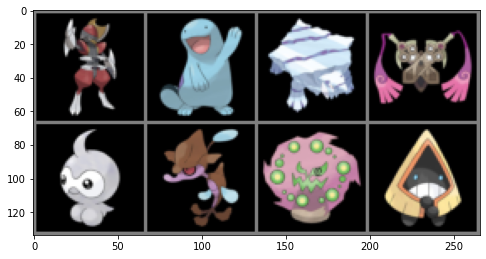

In [ ]:
# выведем картинки из датасета MNIST
images, labels = iter(trainloader).next()
print(images.min())
print(images.max())
plot_images(images[:8], ncol=4)

In [ ]:
class MaskedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, blind_center=False):
        super(MaskedConv2d, self).__init__()
        self.in_channels = in_channels    # число входных каналов
        self.out_channels = out_channels  # число выходных каналов
        self.kernel_size = kernel_size    # размер ядра свертки (как в Conv2d)
        self.bc = blind_center      # флаг с информацией о том, заполнен ли центр ядра нулем
        self.pad = int((self.kernel_size - 1)/2)
        self.layer = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, 
                               kernel_size=self.kernel_size, padding=self.pad, bias=False)   
        
        self.register_buffer('mask', self.layer.weight.data.clone()) # если мы хотим добавить в модель веса
                                                                     # которые будут сохраняться при save(state_dict)
                                                                     # но не должны обновляться при использовании оптимизатора
                                                                     # то используем при инициализации модели self.register_buffer
        self.create_mask(blind_center)
        
    def create_mask(self, mask_type):
        
        k = self.kernel_size
        self.mask[:, :, :k // 2] = 1
        self.mask[:, :, k // 2, :k // 2] = 1
        assert self.in_channels % 3 == 0 and self.out_channels % 3 == 0
        one_third_in, one_third_out = self.in_channels // 3, self.out_channels // 3
        if not mask_type:
            self.mask[:one_third_out, :one_third_in, k // 2, k // 2] = 1
            self.mask[one_third_out:2*one_third_out, :2*one_third_in, k // 2, k // 2] = 1
            self.mask[2*one_third_out:, :, k // 2, k // 2] = 1
        else:
            self.mask[one_third_out:2*one_third_out, :one_third_in, k // 2, k // 2] = 1
            self.mask[2*one_third_out:, :2*one_third_in, k // 2, k // 2] = 1
        
    def forward(self, x):
        self.layer.weight.data *= self.mask
        y = self.layer(x)
        return y

Мы хотим учитывать только контекст предыдущих пикселей (исключая текущий), но при этом не терять часть контекста до рассматриваемого пикселя (как оно случилось в предыдущей ячейке). Поэтому при моделировании сети необходимо поставить blind_center=True только для первого слоя MaskerConv2d (для остальных поставить False).

In [ ]:
# определим класс модели PixelCNN
class PixelCNN(nn.Module):
    def __init__(self, n_channels=30, kernel_size=3, n_layers=12):
        super(PixelCNN, self).__init__()
        self.n_ch = n_channels
        self.k_sz = kernel_size
        self.layer1 = nn.Sequential(
            MaskedConv2d(in_channels=3, out_channels=self.n_ch, kernel_size=self.k_sz, blind_center=True),
            nn.BatchNorm2d(self.n_ch),
            nn.ReLU(),)
        layer_list = []
        for i in range(n_layers):
            layer_list += nn.Sequential(MaskedConv2d(in_channels=self.n_ch, out_channels=self.n_ch, kernel_size=self.k_sz, blind_center=False),
            nn.BatchNorm2d(self.n_ch),
            nn.ReLU(),)
        self.layer2 = nn.Sequential(*layer_list)
        self.layer3 =  nn.Conv2d(in_channels=self.n_ch, out_channels=256*3, kernel_size=1)
        self.cnn = nn.Sequential(self.layer1, self.layer2, self.layer3)
        

    def forward(self, x):
        res = self.cnn(x)
        res = res.view(x.shape[0], 3, 256,
                       64, 64).permute(0, 2, 1, 3, 4)
        return res

Очень важный момент - картинки в датасете MNIST хранятся в формате чисел float из [0,1] - т.е. цвет пикселя может быть любым числом от 0 (черный) до 1 (белый). При этом наша PixelCNN возвращает числа int от 0 до 255 (нулю также соответствует черный, 255 - белый). Поэтому для подсчета лосса исходную картинку необходимо нормировать - для этого я написала отдельную функцию.

In [ ]:
def loss_fn(logits, x):
    """
    считает лосс для модели PixelCNN
    аргументы:
    logits: предсказания (выход) модели - число от 0 до 255
    x: батч изображений (со значениями от 0 до 1)
    """
    batch_size = logits.shape[0]
    loss = nn.CrossEntropyLoss()
    logits = logits.view(batch_size, 256, 3, -1)
    x = x.view(batch_size, 3, -1)
    x = ((255*(x / 2 + 0.5))/1).long()
    return loss(logits, x)

In [ ]:
def generate(net, n_samples, image_size=(64, 64), device=device):
    """
    генерирует картинки с помощью ранее инициализированной/обученной сети
    аргументы:
    net: сеть, которая должна сгенерить картинки
    n_samples: количество сгенерированных картинок
    image_size: размер картинки
    """
    net.eval()
    samples = torch.zeros(n_samples, 3, image_size[0], image_size[1]).to(device)
    
    for i in range(image_size[0]):  # для каждого пикселя возвращается массив "вероятностей" того, что он имеет тот или иной цвет
                                    # т.е. для каждого пикселя каждой картинки из батча возвращается массив размера 256 (для каждого числа от 0 до 255 - вероятность)
        for j in range(image_size[1]): 
              for k in range(3):
                  logits = net(samples)[:, :, k, i, j]
                  probs = F.softmax(logits, dim = 1).data
                  samples[:, k, i, j] = torch.multinomial(probs,
                                                          1).squeeze(-1).float() / 255.
    
    return samples

In [ ]:
# создаем модель
net = PixelCNN(kernel_size=7)
net.to(device)

PixelCNN(
  (layer1): Sequential(
    (0): MaskedConv2d(
      (layer): Conv2d(3, 30, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    )
    (1): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): MaskedConv2d(
      (layer): Conv2d(30, 30, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    )
    (1): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaskedConv2d(
      (layer): Conv2d(30, 30, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    )
    (4): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaskedConv2d(
      (layer): Conv2d(30, 30, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    )
    (7): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaskedConv2d(
      (l

Ниже приведен метод для отрисовки сгенерированных семплов (первый аргумент - массив из картинок, второй - количество столбцов для отрисовки)

In [ ]:
def plot_generated_samples(samples, ncol=12):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.axis('off')
    ax.imshow(
        np.transpose(
            utils.make_grid(samples, nrow=ncol, padding=0, normalize=True).to('cpu'),
            (1,2,0)
        )
     )

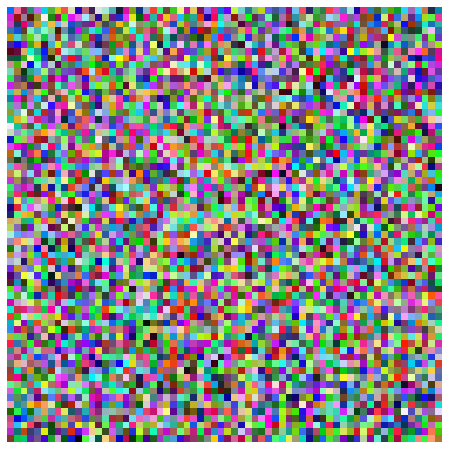

In [ ]:
samples = generate(net, n_samples=1, device=device)
plot_generated_samples(samples, ncol=1)

In [ ]:
epochs = 1000
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

for epoch in range(epochs): 
    losses = []
    for num, (images, targets) in tqdm(enumerate(trainloader), total = len(trainloader)): 
        images = images.to(device)
        logits = net.forward(images)
        
        targets = images
        
        batch_loss = loss_fn(logits, targets)
        losses.append(float(batch_loss.data))
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
    print(f' Epoch {epoch+1} | Average loss {np.mean(losses)}')
    torch.save(net.state_dict(), '/content/drive/MyDrive/ssyp/models/pixelCNN_vanilla1.model')

  0%|          | 0/29 [00:00<?, ?it/s]

 Epoch 1 | Average loss 5.436146374406485


  0%|          | 0/29 [00:00<?, ?it/s]

 Epoch 2 | Average loss 3.876964264902575


  0%|          | 0/29 [00:00<?, ?it/s]

 Epoch 3 | Average loss 2.9786260292447846


  0%|          | 0/29 [00:00<?, ?it/s]

 Epoch 4 | Average loss 2.666365409719533


  0%|          | 0/29 [00:00<?, ?it/s]

 Epoch 5 | Average loss 2.6016710626667945


  0%|          | 0/29 [00:00<?, ?it/s]

 Epoch 6 | Average loss 2.5297268259114234


  0%|          | 0/29 [00:00<?, ?it/s]

 Epoch 7 | Average loss 2.461391605179885


  0%|          | 0/29 [00:00<?, ?it/s]

 Epoch 8 | Average loss 2.428698728824484


  0%|          | 0/29 [00:00<?, ?it/s]

In [ ]:
net.load_state_dict(torch.load('/content/drive/MyDrive/ssyp/models/pixelCNN_vanilla.model', map_location=torch.device('cpu')))
net.eval()

In [ ]:
# generate samples with trained model
with torch.no_grad():
    samples = generate(net, n_samples=10, device=device)
    plot_generated_samples(samples)